In [223]:
import os
import re
import pickle

import pandas as pd
import numpy as np

import sklearn


from sklearn.preprocessing import LabelEncoder
#from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import cv2

import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.image import resize_with_pad
from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    ImageDataGenerator,
    array_to_img,
    save_img
)

In [2]:
pd.__version__

'1.4.4'

A function for classification models

In [213]:
def lr_analysis(solver, x, y, modelname=''):
    solver.fit(x, y)
    model_score = solver.score(x, y)
    print('==============================================================================================================')
    print(f'Analysis of the Model {modelname} ')
    print('-------------------------------------------------------------------')

    print(f'- Model Score : {model_score}')
        
    model_pred = solver.predict(x) 
    model_soft_pred = solver.predict_proba(x)
    loss_func = log_loss(y, model_soft_pred)
    print(f'- Cost Function: {loss_func}')
    print('\n')
    print(f'- Hard classification of the model {modelname}: {model_pred}')
    print(f'- Soft classfication of the model {modelname}: {model_soft_pred}')
    print('--------------------------------------------------------------------------------------------------------------')
    acc = accuracy_score(y, model_pred)
    pcs = precision_score(y, model_pred, average='micro')
    rec = recall_score(y, model_pred, average='micro')
    f1s = f1_score(y, model_pred, average='micro')
        
    print(f'Classification metrics of the model {modelname}')
    print('- Accuracy: ', acc)
    print('- Precision: ', pcs)
    print('- Recall: ', rec)
    print('- F1 Score: ', f1s)
    print('==============================================================================================================')
    return model_soft_pred, model_score, model_pred, acc, pcs, rec, f1s

## Image preprocessing and basic EDA

I have used the code from the officehour for loading and standardizing  the images.


In [16]:
DIR_PATH = os.path.abspath('C:/temp_workfolder/rbc_original')
folders = os.listdir(DIR_PATH)

# find the largest image shape for reference
# to select the right target size
max_img_size = 0
max_img_shape = None

for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)

        img = load_img(img_path)
        img_shape = img_to_array(img).shape
        width, height, __ = img_shape
        curr_img_size = width * height
        
        if curr_img_size > max_img_size or not max_img_size:
            max_img_size = curr_img_size
            max_img_shape = img_shape
            
max_img_shape

(65, 92, 3)

Target size of the images will differ from models. Same applies to DL based learning

In [17]:
TARGET_HEIGHT = 48
TARGET_WIDTH = 48

def preprocess_img_to_arr(img, target_height = TARGET_HEIGHT, target_width = TARGET_WIDTH):
    img_arr = np.asarray(img)
    img_tensor = tf.convert_to_tensor(img_arr)

    new_img_arr = resize_with_pad(
        img_tensor, 
        target_height, 
        target_width, 
        method = 'nearest',
        antialias = True
    )
    
    return new_img_arr

In [9]:
os.path.exists('C:/temp_workfolder/test')

False

In [18]:
# store preprocessed images in new folder
NEW_DIR_PATH = os.path.abspath('C:/temp_workfolder/rbc_preproc1')
if os.path.exists(NEW_DIR_PATH) == False:     #creates a folder if it doesn't exist
        os.mkdir(NEW_DIR_PATH)
    
for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    new_folder_path = os.path.join(NEW_DIR_PATH, folder)
    if os.path.exists(new_folder_path) == False:     #creates a folder if it doesn't exist
        os.mkdir(new_folder_path)
    
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)
        new_img_path = os.path.join(new_folder_path, img)
        
        img = load_img(img_path)
        img_arr = preprocess_img_to_arr(img)
        save_img(new_img_path, img_arr)

In [19]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
)

In [20]:
generator = datagen.flow_from_directory(
    NEW_DIR_PATH,
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 32,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

Found 7108 images belonging to 9 classes.


In [21]:
def clean_name(name):
    name = (
        re
        .sub(r'\d+', '', name) # remove digits
        .strip() # remove whitespace
    )
    return name


label_to_name_dict = {label: clean_name(name) for name, label in generator.class_indices.items()}
label_to_name_dict

{0: 'acantocyte',
 1: 'elliptocyte',
 2: 'hypochromic',
 3: 'normal',
 4: 'pencil',
 5: 'spero_bulat',
 6: 'stomatocyte',
 7: 'targetsel',
 8: 'teardrop'}

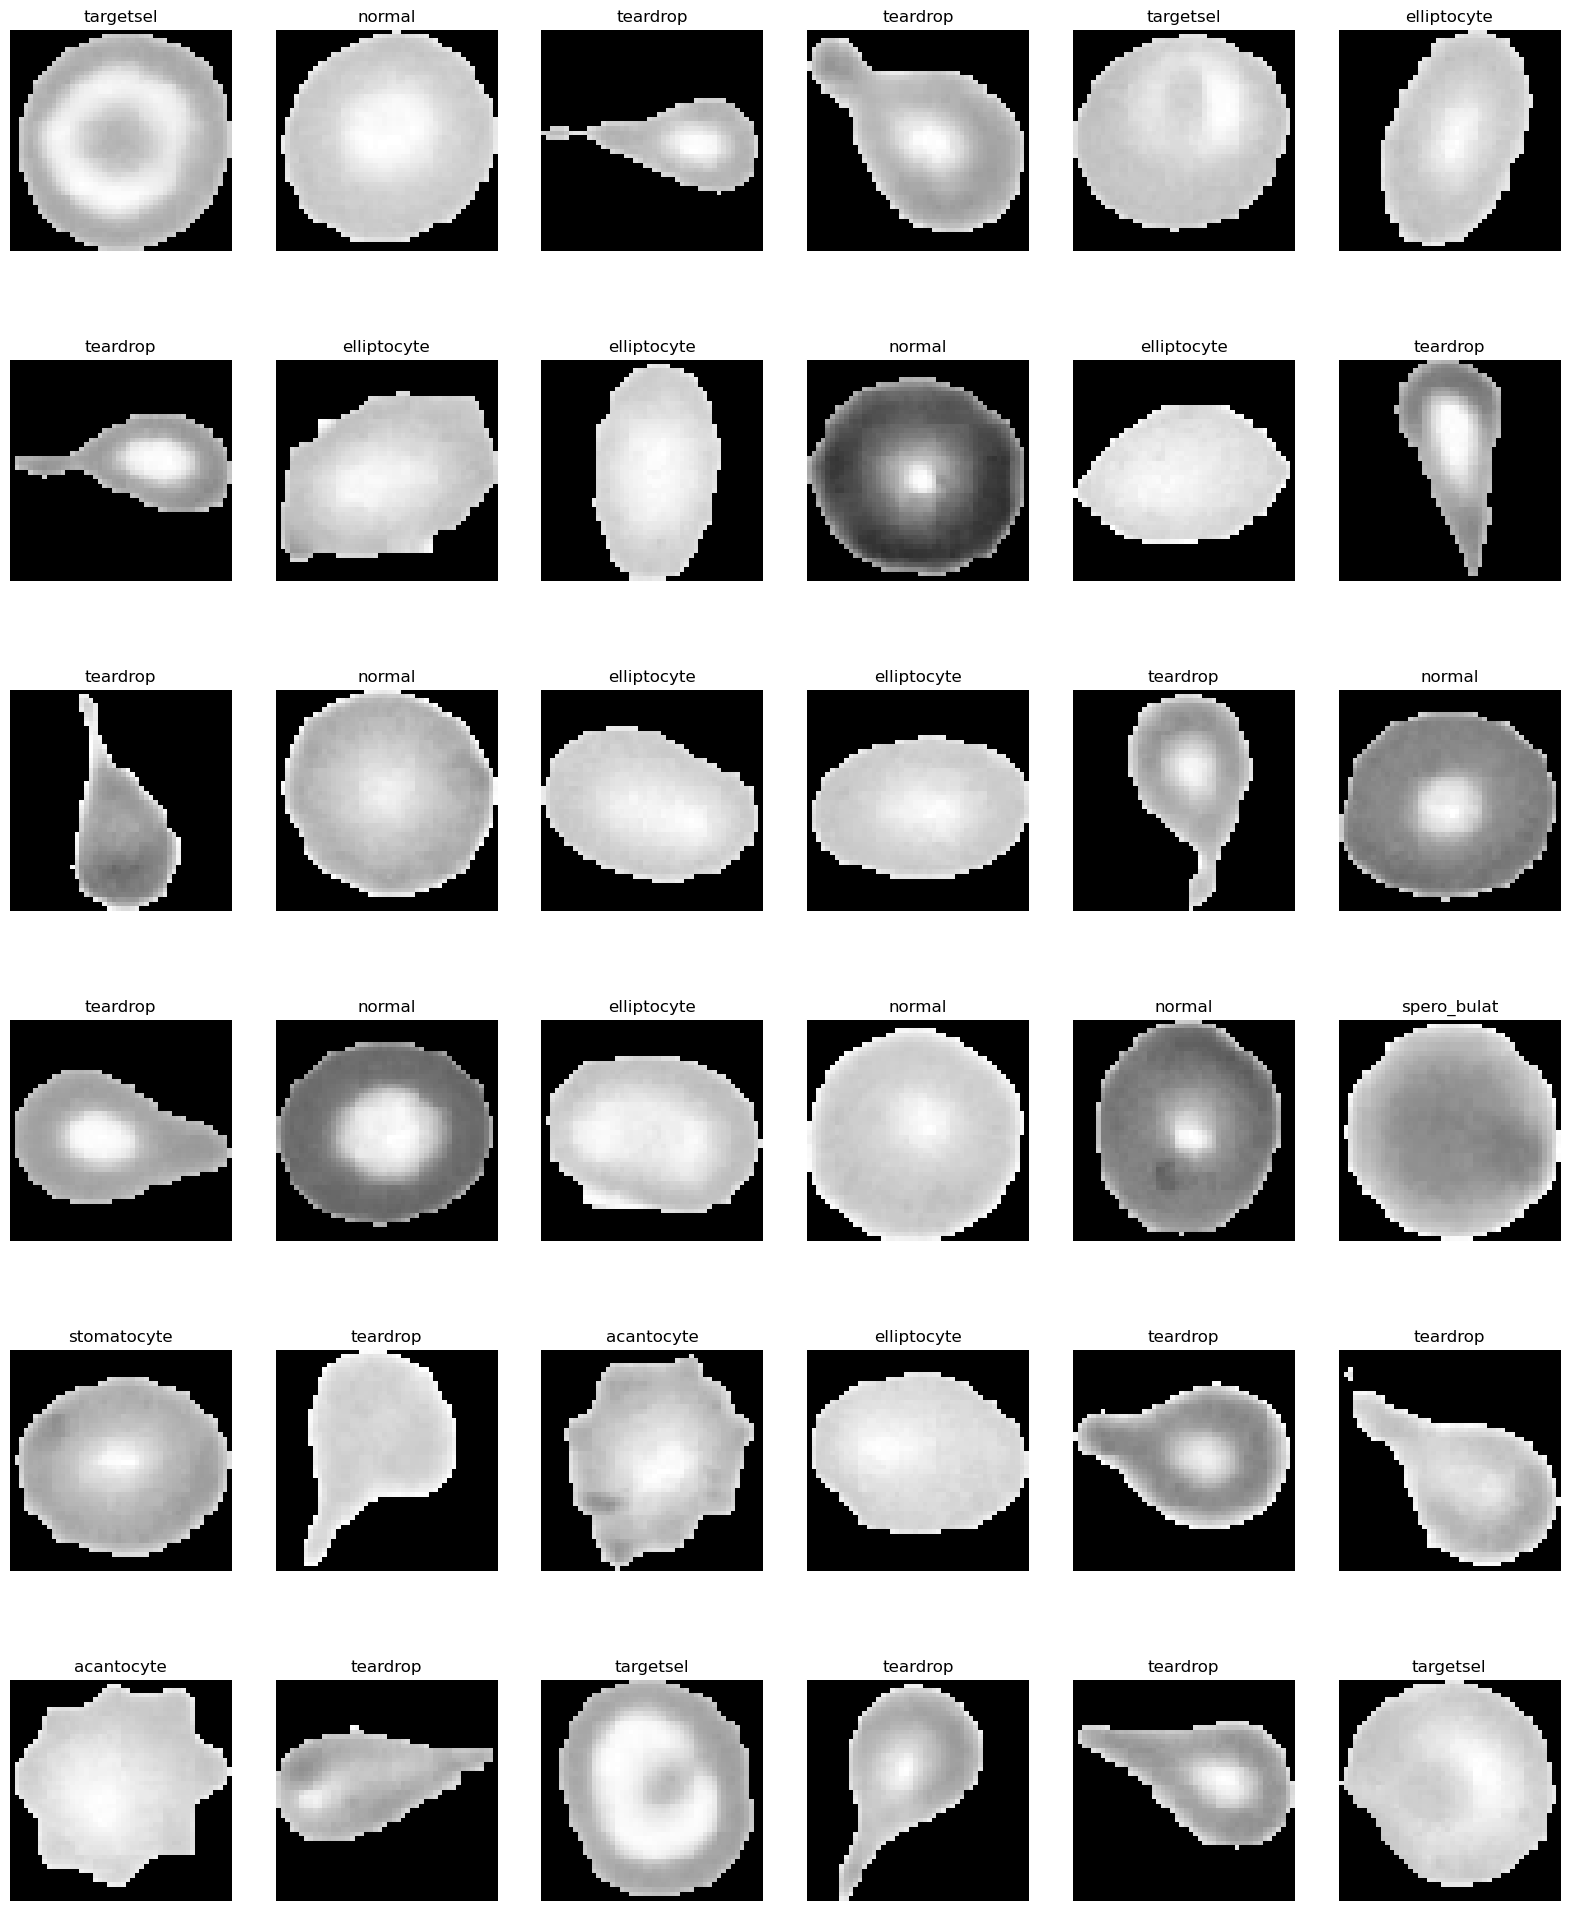

In [22]:
# sample a few images
num_rows, num_cols = 6, 6
num_imgs = num_rows * num_cols

plt.figure(figsize=(20, 25))

# these images can be used for both non-deep-learning and deep-learning applications
for idx in range(num_imgs):
    img, label_arr = generator.next()
    label = np.argmax(label_arr)
    name = label_to_name_dict[label]
    plt.subplot(num_rows, num_cols, idx + 1, title = name)

    plt.imshow(img[0])
    plt.axis('off')

===================================


## 0. Preprocessing for non-DL models: Turning the images into pixel arrays


In [4]:
# I've relocated the split images into a new foler

dir_path2 = "C:/temp_workfolder/rbc_preproc1_1"

dir_list = os.listdir(dir_path2)
dir_list

['acantocyte',
 'elliptocyte',
 'hypochromic',
 'normal',
 'pencil',
 'spero_bulat',
 'stomatocyte',
 'targetsel',
 'teardrop']

In [25]:
os.path.join(dir_path2,dir_list[8])

'C:/temp_workfolder/rbc_preproc1_1\\teardrop'

In [27]:
img_list = []
class_list = []

for i in range(len(dir_list)):
    print(dir_list[i])
    shape_class = dir_list[i]
    shape_path = os.path.join(dir_path2,dir_list[i])
    for img_file in tqdm(os.listdir(shape_path)):
        img_file_path = os.path.join(shape_path, img_file)
        img_file_load = load_img(img_file_path)
        #img_file_arr = np.asarray(img_file_load)  #/255                #turning the image into an array. divide by 255 although it kind of is a grayscale image
        img_file_arr = img_to_array(img_file_load)
        img_file_arr = np.transpose(img_file_arr.flatten())             #flattening the array
        #print('#', end ='')
        img_list.append(img_file_arr)
        class_list.append(shape_class)
        

acantocyte


100%|████████████████████████████████████████████████████████████████| 354/354 [00:00<00:00, 1861.39it/s]


elliptocyte


100%|██████████████████████████████████████████████████████████████| 1211/1211 [00:00<00:00, 1976.96it/s]


hypochromic


100%|████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 1848.20it/s]


normal


100%|██████████████████████████████████████████████████████████████| 1426/1426 [00:00<00:00, 1909.79it/s]


pencil


100%|██████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1844.46it/s]


spero_bulat


100%|████████████████████████████████████████████████████████████████| 562/562 [00:00<00:00, 1942.82it/s]


stomatocyte


100%|████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 1947.21it/s]


targetsel


100%|████████████████████████████████████████████████████████████████| 851/851 [00:00<00:00, 1945.60it/s]


teardrop


100%|██████████████████████████████████████████████████████████████| 2076/2076 [00:01<00:00, 1105.19it/s]


In [28]:
df_img_list = pd.DataFrame(img_list)
df_img_list['type'] = class_list
        #print('@', end ='')

In [174]:
df_img_list = pd.read_pickle('C:/Git Storage/DLF/df_img_list_full.pickle')

In [222]:
df_img_list

,0,1,2,3,4,5,6,7,8,9,...,6903,6904,6905,6906,6907,6908,6909,6910,6911,type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acantocyte
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acantocyte
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acantocyte
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acantocyte
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acantocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,teardrop
7104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,teardrop
7105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,teardrop
7106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,teardrop


- Now I will process the dataframe in order to use it for non deep learning models

In [179]:
X = df_img_list.iloc[:,0:6912]
y = pd.DataFrame(df_img_list.iloc[:,6912])

In [182]:
le = LabelEncoder()
y['type_le'] = le.fit_transform(y['type'])

In [183]:
y

,type,type_le
0,acantocyte,0
1,acantocyte,0
2,acantocyte,0
3,acantocyte,0
4,acantocyte,0
...,...,...
7103,teardrop,8
7104,teardrop,8
7105,teardrop,8
7106,teardrop,8


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state = 111)

In [186]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


## 1. EDA with PCA (2-component) 

In [187]:
from sklearn.decomposition import PCA
pca_baseline = PCA(n_components=2)
principalComponents = pca_baseline.fit_transform(X_train)

In [188]:
principalDf = pd.DataFrame(principalComponents,
                           columns = ['Component 1', 'Component 2']
                          )

In [189]:
principalDf

,Component 1,Component 2
0,-8.525036,7.596269
1,14.852468,-8.298634
2,12.421590,-3.785012
3,1.387309,1.155800
4,17.962494,-5.334714
...,...,...
5326,-18.780527,-3.400930
5327,-14.848509,-5.828483
5328,-0.249071,4.249992
5329,26.044540,-3.057365


In [190]:
y_train_r = y_train.reset_index(drop=True)

In [191]:
finalDf = pd.concat([principalDf, y_train_r], axis = 1)
finalDf

,Component 1,Component 2,type,type_le
0,-8.525036,7.596269,spero_bulat,5
1,14.852468,-8.298634,teardrop,8
2,12.421590,-3.785012,teardrop,8
3,1.387309,1.155800,normal,3
4,17.962494,-5.334714,teardrop,8
...,...,...,...,...
5326,-18.780527,-3.400930,targetsel,7
5327,-14.848509,-5.828483,targetsel,7
5328,-0.249071,4.249992,normal,3
5329,26.044540,-3.057365,teardrop,8


In [192]:
dir_list = ['acantocyte',
 'elliptocyte',
 'hypochromic',
 'normal',
 'pencil',
 'spero_bulat',
 'stomatocyte',
 'targetsel',
 'teardrop']

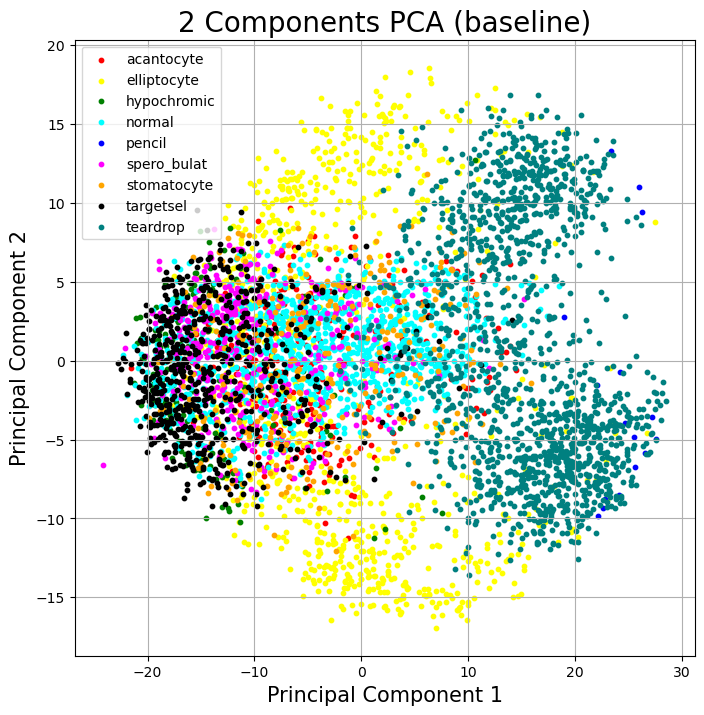

In [198]:
#referred from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Components PCA (baseline)', fontsize = 20)
targets = dir_list
colors = ['red', 'yellow', 'green', 'cyan', 'blue', 'magenta', 'orange', 'black', 'teal']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['type'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Component 1']
               , finalDf.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 10)
ax.legend(dir_list)
ax.grid()

### Now, apply the model to test set

In [199]:
principalComponents_test = pca_baseline.fit_transform(X_test)
principalDf_test = pd.DataFrame(principalComponents_test,
                           columns = ['Component 1', 'Component 2']
                          )

y_test_r = y_test.reset_index(drop=True)
finalDf_test = pd.concat([principalDf_test, y_test_r], axis = 1)
finalDf_test

,Component 1,Component 2,type,type_le
0,-2.117435,2.871278,normal,3
1,19.974556,-8.984864,teardrop,8
2,14.482100,8.660523,teardrop,8
3,8.179239,6.316237,targetsel,7
4,-10.592056,3.210824,acantocyte,0
...,...,...,...,...
1772,4.789891,-0.101384,teardrop,8
1773,-12.377599,-6.951567,targetsel,7
1774,22.830124,13.058450,teardrop,8
1775,-12.815889,1.371226,targetsel,7


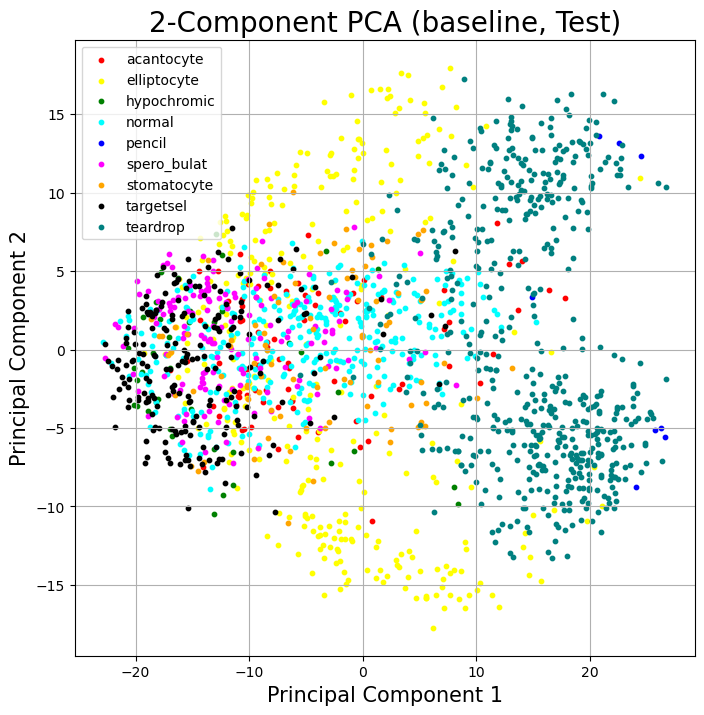

In [224]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2-Component PCA (baseline, Test)', fontsize = 20)
targets = dir_list
colors = ['red', 'yellow', 'green', 'cyan', 'blue', 'magenta', 'orange', 'black', 'teal']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf_test['type'] == target
    ax.scatter(finalDf_test.loc[indicesToKeep, 'Component 1']
               , finalDf_test.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

- Cell types that have more distinguishable shape shows some variation (i.e., teardrop, ellipse). Other RBCs that have rounder shape are not well discriminated against normal cells.
- Then how many components should I keep to obtain 'adequate' variance (say 0.9~0.95)?

## 2. Performing PCA before classification modeling

In [201]:
from sklearn.decomposition import PCA
pca_var = PCA(n_components=0.95)
principalComponents_var = pca_var.fit(X_train)

In [202]:
print(f'Keeping {principalComponents_var.n_components_} components ahieve variance of 0.95') 

Keeping 507 components ahieve variance of 0.95


- Visualizing PCA with 507 components is rather difficult.
- Instead, I go ahead and will feed the PCA model with 0.95 variance into some classification models.

In [204]:
X_train_pca_var = pca_var.transform(X_train)
X_test_pca_var = pca_var.transform(X_test)

## 3. Classification - Decision Tree

In [205]:
dtree = DecisionTreeClassifier(max_depth = 2)

Train dataset

In [214]:
dtree_train = lr_analysis(dtree, X_train_pca_var, y_train['type'], modelname='DecisionTreeClassifier_Train')

Analysis of the Model DecisionTreeClassifier_Train 
-------------------------------------------------------------------
- Model Score : 0.5811292440442694
- Cost Function: 1.2747342819877303


- Hard classification of the model DecisionTreeClassifier_Train: ['normal' 'teardrop' 'teardrop' ... 'normal' 'teardrop' 'normal']
- Soft classfication of the model DecisionTreeClassifier_Train: [[6.25678119e-02 3.54430380e-02 5.31645570e-02 ... 9.00542495e-02
  2.16274864e-01 2.89330922e-02]
 [1.55957580e-02 5.48970680e-02 6.23830318e-04 ... 1.49719276e-02
  1.87149095e-03 8.57142857e-01]
 [1.55957580e-02 5.48970680e-02 6.23830318e-04 ... 1.49719276e-02
  1.87149095e-03 8.57142857e-01]
 ...
 [6.25678119e-02 3.54430380e-02 5.31645570e-02 ... 9.00542495e-02
  2.16274864e-01 2.89330922e-02]
 [1.55957580e-02 5.48970680e-02 6.23830318e-04 ... 1.49719276e-02
  1.87149095e-03 8.57142857e-01]
 [6.25678119e-02 3.54430380e-02 5.31645570e-02 ... 9.00542495e-02
  2.16274864e-01 2.89330922e-02]]
------------

Fitting test dataset with Decision Tree model fed with PCA 

In [215]:
dtree_test = lr_analysis(dtree, X_test_pca_var, y_test['type'], modelname='DecisionTreeClassifier_Train')

Analysis of the Model DecisionTreeClassifier_Train 
-------------------------------------------------------------------
- Model Score : 0.5931344963421497
- Cost Function: 1.2253989722621252


- Hard classification of the model DecisionTreeClassifier_Train: ['normal' 'teardrop' 'teardrop' ... 'teardrop' 'normal' 'normal']
- Soft classfication of the model DecisionTreeClassifier_Train: [[0.06097561 0.03991131 0.03325942 ... 0.09312639 0.20066519 0.04767184]
 [0.01581028 0.02766798 0.         ... 0.00395257 0.         0.91897233]
 [0.01581028 0.02766798 0.         ... 0.00395257 0.         0.91897233]
 ...
 [0.01581028 0.02766798 0.         ... 0.00395257 0.         0.91897233]
 [0.06097561 0.03991131 0.03325942 ... 0.09312639 0.20066519 0.04767184]
 [0.06097561 0.03991131 0.03325942 ... 0.09312639 0.20066519 0.04767184]]
--------------------------------------------------------------------------------------------------------------
Classification metrics of the model DecisionTreeClassifie

- Plotting a confusion matrix to visualize classification performance.

[Text(0.5, 23.38159722222222, 'Predicted'),
 Text(50.58159722222221, 0.5, 'Actual')]

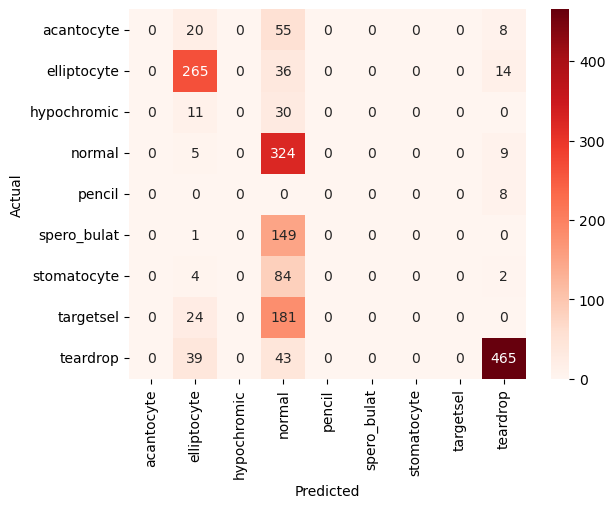

In [217]:
cm = confusion_matrix(y_test['type'], dtree_test[2])
hm = sns.heatmap(cm,
                 annot=True,
                 cmap='Reds',
                 fmt='d',
                 xticklabels=dir_list,
                 yticklabels=dir_list)
hm.set(xlabel='Predicted', ylabel='Actual')

- Decision tree model seems to fail to classify many of the cell types.

## 4. Classification - Naive Bayes

In [219]:
gnb = GaussianNB()
gnb_train = lr_analysis(gnb, X_train_pca_var, y_train['type'], modelname='DecisionTreeClassifier_Naive Bayes')

Analysis of the Model DecisionTreeClassifier_Naive Bayes 
-------------------------------------------------------------------
- Model Score : 0.8388670043143875
- Cost Function: 1.1828987115510083


- Hard classification of the model DecisionTreeClassifier_Naive Bayes: ['spero_bulat' 'teardrop' 'teardrop' ... 'normal' 'teardrop' 'normal']
- Soft classfication of the model DecisionTreeClassifier_Naive Bayes: [[3.33921696e-14 4.93186002e-11 5.43247389e-06 ... 1.47939398e-05
  1.39736897e-03 1.12577930e-14]
 [1.01780181e-18 1.02784289e-10 2.30803862e-25 ... 1.44230786e-23
  5.99677823e-24 1.00000000e+00]
 [1.24073729e-21 7.25329966e-13 1.67028136e-44 ... 4.22091465e-42
  4.11431030e-41 1.00000000e+00]
 ...
 [5.94291296e-25 2.94044676e-18 2.00260871e-04 ... 3.12445444e-03
  1.88052101e-04 1.71415016e-24]
 [1.31163243e-15 5.51666512e-08 5.27214545e-15 ... 3.45846682e-06
  1.85036970e-14 9.99996486e-01]
 [1.05482160e-31 1.42395553e-28 3.14301044e-09 ... 2.02284307e-05
  7.38852570e-09 1.5517

In [220]:
gnb_test = lr_analysis(gnb, X_test_pca_var, y_test['type'], modelname='DecisionTreeClassifier_Naive Bayes')

Analysis of the Model DecisionTreeClassifier_Naive Bayes 
-------------------------------------------------------------------
- Model Score : 0.9144625773776027
- Cost Function: 0.6078234042617516


- Hard classification of the model DecisionTreeClassifier_Naive Bayes: ['normal' 'normal' 'teardrop' ... 'teardrop' 'normal' 'normal']
- Soft classfication of the model DecisionTreeClassifier_Naive Bayes: [[1.35857853e-35 4.33473336e-27 5.09989926e-13 ... 1.62384045e-04
  2.16097517e-11 1.15020980e-27]
 [3.09228032e-20 2.75300746e-07 5.68477426e-02 ... 1.31194779e-01
  4.39917717e-04 4.05130651e-01]
 [3.50518920e-16 2.70115077e-10 3.89395473e-29 ... 9.35806265e-18
  1.06240842e-18 1.00000000e+00]
 ...
 [2.62831394e-15 3.02131154e-14 3.90211335e-41 ... 1.84734713e-44
  1.37608689e-38 1.00000000e+00]
 [3.22093505e-35 7.44781975e-25 2.80544291e-11 ... 3.11567753e-06
  2.36761747e-04 1.35458832e-28]
 [3.48292224e-34 2.32492865e-26 7.04477629e-15 ... 3.77046103e-05
  5.34007733e-09 1.85683499e-2

[Text(0.5, 23.999999999999986, 'Predicted'),
 Text(24.000000000000014, 0.5, 'Actual')]

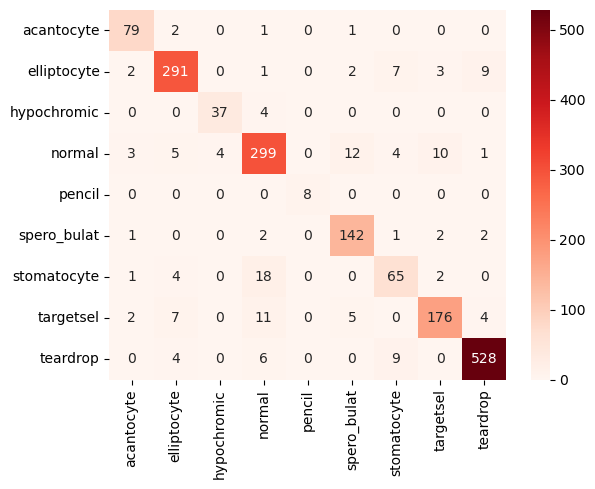

In [221]:
cm_gnb = confusion_matrix(y_test['type'], gnb_test[2])
hm_gnb = sns.heatmap(cm_gnb,
                 annot=True,
                 cmap='Reds',
                 fmt='d',
                 xticklabels=dir_list,
                 yticklabels=dir_list)
hm.set(xlabel='Predicted', ylabel='Actual')

Naive Bayes actually was a late addition to the non-DL baseline modelling, but its performance is actually quite good...